# **<center>Chess Piece Classification</center>**

dataset link : https://www.kaggle.com/niteshfre/chessman-image-dataset

The dataset contains multiple different kinds of images of chess piece with their corresponding folder named according to their class. The goal is to classify the pieces. classification of chess piece is very useful to track chess matches in an automated process.

The classes are - [ 'Bishop', 'Queen', 'Pawn', 'Rook', 'King', 'Knight' ]

### **Library Loading**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

import torchvision
from torchvision import datasets, models, transforms

from timeit import default_timer as timer

KeyboardInterrupt: 

### **Checking for data imbalance**

In [5]:
classes = ['Bishop', 'Queen', 'Pawn', 'Rook', 'King', 'Knight']

In [6]:
def data_count(main_path = 'Chessman-image-dataset/Chess'):
    counts = {}
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts

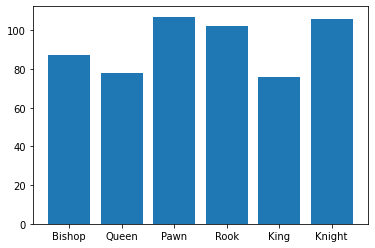

In [7]:
counts = data_count()
plt.bar(list(counts.keys()),list(counts.values()))
plt.show()

clearly their is almost same amount of data in each class. Next we shall split the data into training (75%) and validation (25%) maintainig the class balance.

### **Train-Valid Split**

In [8]:
def data_split(main_path = 'Chessman-image-dataset/Chess', split_percentage = 0.25):
    train_dict = {}
    valid_dict = {}
    counts = data_count(main_path)
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in ['Queen', 'Bishop', 'Knight', 'Rook', 'Pawn', 'King']:
            file_paths = [os.path.join(root,files[i]) for i in range(len(files))]
            
            valid_idxs = np.random.randint(low=0,high=len(files),size=int(len(files)*split_percentage))
            train_idxs = list(set(range(0,len(files))) - set(valid_idxs))
            
            train_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in train_idxs]
            valid_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in valid_idxs]
            
    return train_dict, valid_dict

In [9]:
train_dict, valid_dict = data_split()

In [10]:
def visualize(data_dict):    
    idx = np.random.randint(0,min(list([len(l) for l in data_dict.values()])))

    plt.figure(figsize=(20,6))
    plt.subplot(161)
    plt.imshow(cv2.imread(train_dict['Bishop'][idx]).astype(int))
    plt.title('Bishop')
    plt.subplot(162)
    plt.imshow(cv2.imread(train_dict['King'][idx]).astype(int))
    plt.title('King')
    plt.subplot(163)
    plt.imshow(cv2.imread(train_dict['Knight'][idx]).astype(int))
    plt.title('Knight')
    plt.subplot(164)
    plt.imshow(cv2.imread(train_dict['Pawn'][idx]).astype(int))
    plt.title('Pawn')
    plt.subplot(165)
    plt.imshow(cv2.imread(train_dict['Queen'][idx]).astype(int))
    plt.title('Queen')
    plt.subplot(166)
    plt.imshow(cv2.imread(train_dict['Rook'][idx]).astype(int))
    plt.title('Rook')

    plt.show()

In [11]:
train_dict.keys()

dict_keys(['Bishop', 'Queen', 'Pawn', 'Rook', 'King', 'Knight'])

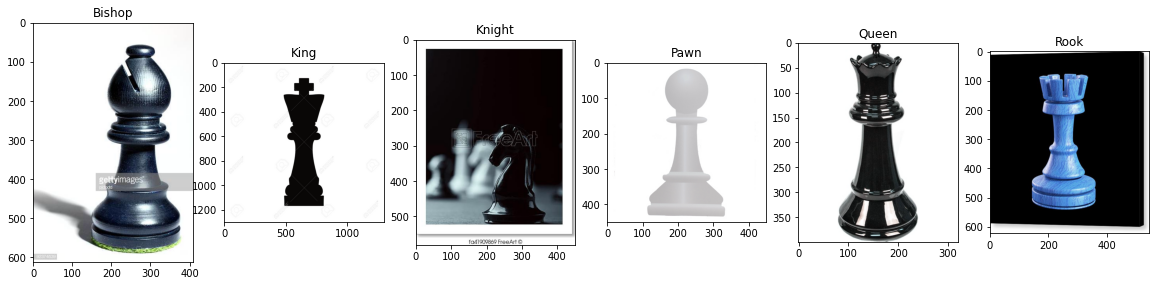

In [12]:
# training data
visualize(train_dict)

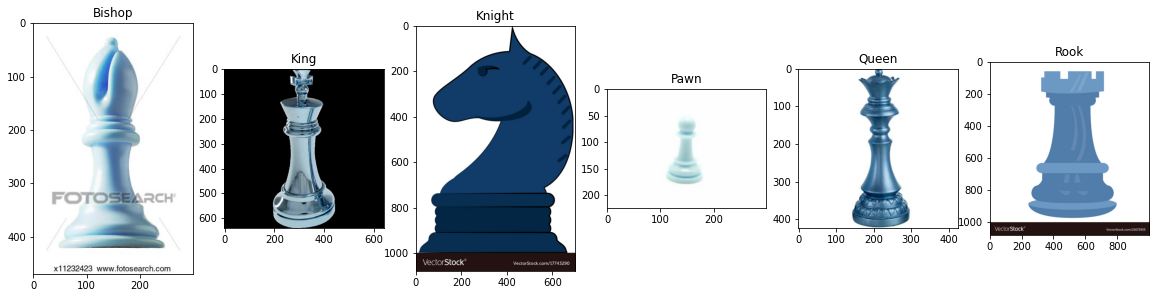

In [13]:
# validation data
visualize(valid_dict)

In [14]:
print('training data sizes : ', [len(l) for l in train_dict.values()])
print('validation data sizes : ', [len(l) for l in valid_dict.values()])

training data sizes :  [66, 60, 84, 80, 60, 82]
validation data sizes :  [21, 19, 26, 25, 19, 26]


In [15]:
## dataset class

class ChessData(Dataset):
    """Chess Piece Dataset class"""
    
    def __init__(self, data_dict, transform=None):
        """
        Args:
            data_dict (dict): dictionary with class as key and the corresponding paths to the data of that class 
        """
        self.data_dict = data_dict
        self.transform = transform
        
    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])
    
    def __getitem__(self,idx):
        counts = [len(l) for l in self.data_dict.values()]
        sum_counts = list(np.cumsum(counts))
        sum_counts = [0] + sum_counts + [np.inf]
        
        for c,v in enumerate(sum_counts):
            if idx < v:
                i = (idx - sum_counts[c-1]) - 1
                break
        #print(c,i,idx)
        label = list(self.data_dict.keys())[c-1]
        img = Image.open(self.data_dict[str(label)][i]).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
        return img, classes.index(str(label))

As the number of data per class is not too much, so data augmentation plays a vital role in here.

In [16]:
#  data augmentation

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

chessdata_train = ChessData(train_dict,transform = data_transform)
chessdata_valid = ChessData(valid_dict,transform = data_transform)

Total Number of training images :  432
Total Number of validation images :  136


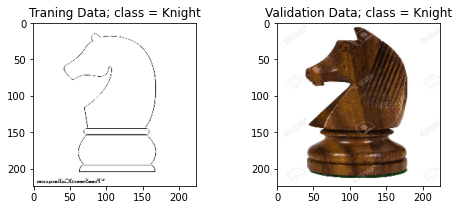

In [17]:
t_idx = np.random.randint(0,len(chessdata_train))
v_idx = np.random.randint(0,len(chessdata_valid))

print("Total Number of training images : ", len(chessdata_train))
print("Total Number of validation images : ", len(chessdata_valid))

t_img,t_label = chessdata_train[t_idx]
v_img,v_label = chessdata_valid[v_idx]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1,2,0))
plt.title(f'Traning Data; class = {classes[t_label]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1,2,0))
plt.title(f'Validation Data; class = {classes[v_label]}')
plt.show()

In [18]:
# definning data loader

train_loader = DataLoader(chessdata_train, batch_size=50, shuffle=True)
valid_loader = DataLoader(chessdata_valid, batch_size=50, shuffle=True)

In [19]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),sample_batched[1])
    print(type(sample_batched[0]))
    break

0 torch.Size([50, 3, 224, 224]) tensor([3, 4, 2, 2, 2, 4, 0, 3, 3, 3, 3, 4, 1, 2, 3, 2, 2, 1, 5, 1, 5, 1, 0, 2,
        4, 5, 1, 4, 2, 2, 5, 4, 2, 2, 0, 0, 2, 5, 4, 5, 5, 3, 5, 0, 1, 0, 0, 2,
        4, 3])
<class 'torch.Tensor'>


In [20]:
# definnig the loss function

import torch.optim as optim
import torch.nn as nn

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

we are using the binary cross entropy loss here and as we are going to use the ResNet architechture the loss surface is going to be rough and messy. Lets see which optimizer gives the best result.

### **Model define**

In [21]:
#Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [23]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [24]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("training on gpu...")
    vgg16.cuda()
else:
    print("no gpu found.")

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
print(vgg16)

training on gpu...
6
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

In [25]:
def base_model_build():
    #Load the pretrained model from pytorch
    vgg16 = models.vgg16(pretrained=True)

    # print out the model structure
    #print(vgg16)
    
    # Freeze training for all "features" layers
    for param in vgg16.features.parameters():
        param.requires_grad = False
        
    import torch.nn as nn

    n_inputs = vgg16.classifier[6].in_features

    # add last linear layer (n_inputs -> 5 flower classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes))

    vgg16.classifier[6] = last_layer

    # if GPU is available, move the model to GPU
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("training on gpu...")
        vgg16.cuda()
    else:
        print("no gpu found.")

    # check to see that your last layer produces the expected number of outputs
    #print(vgg16.classifier[6].out_features)
    #print(vgg16)
    
    return vgg16


def loss_acc_visuaize(history,optim,path):
    plt.figure(figsize=(20,10))

    plt.suptitle(str(optim))

    plt.subplot(121)
    plt.plot(history['train_loss'],label='train_loss')
    plt.plot(history['valid_loss'],label='valid_loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(122)
    plt.plot(history['train_acc'],label='train_acc')
    plt.plot(history['valid_acc'],label='valid_acc')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.savefig(str(path) + 'loss_acc.png')


def grad_visualize(history,optim,path,ylimit=10):
    # gadient norm distribution

    import seaborn as sns

    plt.figure(figsize=(20,10))

    plt.suptitle(str(optim))

    plt.subplot(131)
    sns.kdeplot(weight_grads1, shade=True)
    sns.kdeplot(bias_grads1, shade=True)
    plt.legend(['weight','bias'])
    plt.title('Linear layer 1')
    #plt.gca().set_xlim(left=0)
    plt.ylim(0,ylimit)

    plt.subplot(132)
    sns.kdeplot(weight_grads2, shade=True)
    sns.kdeplot(bias_grads2, shade=True)
    plt.legend(['weight','bias'])
    plt.title('Linear layer 2')
    #plt.gca().set_xlim(left=0)
    plt.ylim(0,ylimit)

    plt.subplot(133)
    sns.kdeplot(weight_grads3, shade=True)
    sns.kdeplot(bias_grads3, shade=True)
    plt.legend(['weight','bias'])
    plt.title('Linear layer 3')
    #plt.gca().set_xlim(left=0)
    plt.ylim(0,ylimit)
    
    plt.savefig(str(path) + 'grad_norms.png')
    

def visual_predict(model,data=chessdata_valid):
    c = np.random.randint(0,len(data))
    img, label = data[c]

    with torch.no_grad():
            model.eval()
            # Model outputs log probabilities
            out = model(img.view(1,3,224,224).cuda())
            out = torch.exp(out)
            print(out)

    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title(str(classes[label]))
    plt.subplot(122)
    plt.barh(classes,out.cpu().numpy()[0])

    plt.show()
    

def class_accuracies(model,data_dict=valid_dict,classes=classes):
    accuracy_dict = {}
    with torch.no_grad():
        model.eval()
        for c in data_dict.keys():
            correct_count = 0
            total_count = len(data_dict[str(c)])
            gt = classes.index(str(c))
            for path in data_dict[str(c)]:
                #print(path)
                im = Image.open(path).convert('RGB')
                #im.show()
                im = transforms.ToTensor()(im)
                im = transforms.Resize((224,224))(im)
                out = model(im.view(1,3,224,224).cuda())
                #print(out)
                out = torch.exp(out)
                pred = list(out.cpu().numpy()[0])
                #print(pred)
                pred = pred.index(max(pred))
                #print(pred,gt)

                if gt == pred:
                    correct_count += 1
            print(f"Accuracy for class {str(c)} : ",correct_count/total_count)
            accuracy_dict[str(c)] = correct_count/total_count
    return accuracy_dict

## **SGD**

In [49]:
vgg16=base_model_build()
optimizer_sgd = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_sgd
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/SGD/vgg16-transfer-chess-sgd-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.



/home/sysadm/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0	100.00% complete. 24.05 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.8813 	Validation Loss: 1.7410
		Training Accuracy: 17.82%	 Validation Accuracy: 25.00%
Epoch: 1	100.00% complete. 17.82 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.8133 	Validation Loss: 1.6689
		Training Accuracy: 21.06%	 Validation Accuracy: 38.97%
Epoch: 2	100.00% complete. 16.30 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.7170 	Validation Loss: 1.6266
		Training Accuracy: 27.08%	 Validation Accuracy: 43.38%
Epoch: 3	100.00% complete. 17.61 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.6346 	Validation Loss: 1.5749
		Training Accuracy: 34.26%	 Validation Accuracy: 44.85%
Epoch: 4	100.00% complete. 16.29 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.6213 	Validation Loss: 1.5230
		Training Accuracy: 37.04%	 Validation Accuracy: 46.32%
Epoch: 5	100.00% complete. 17.36 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.5752 	Validation Loss: 1.5011
		Training Accuracy

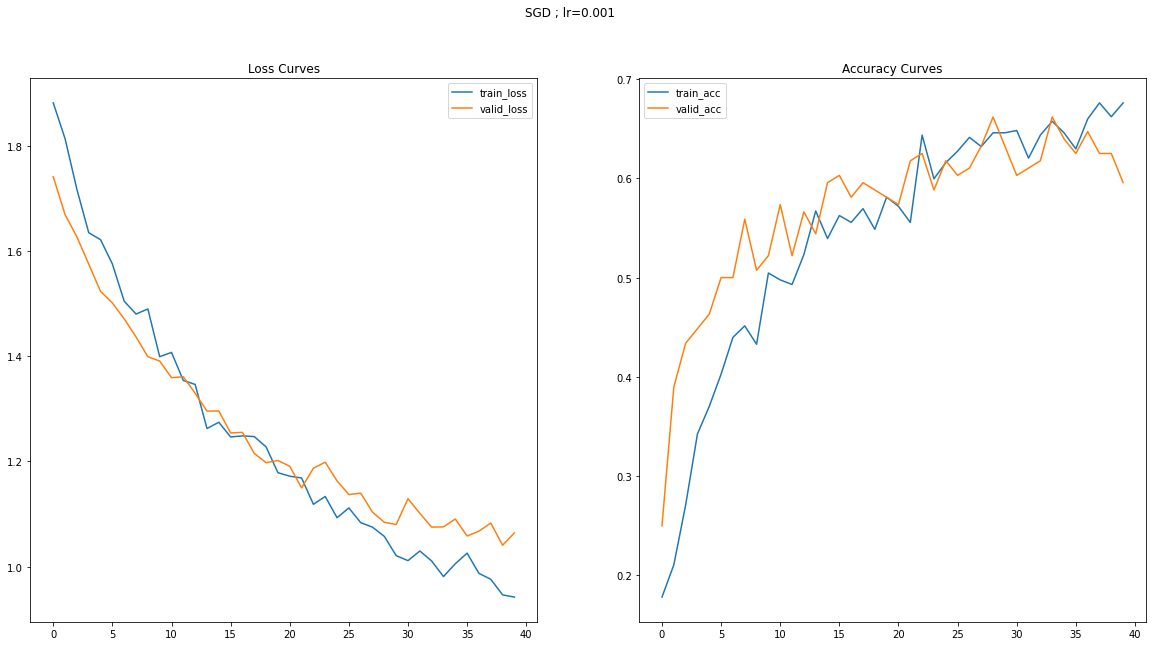

In [50]:
loss_acc_visuaize(history,optim='SGD ; lr=0.001',path='plots/SGD/lr=0.001/')

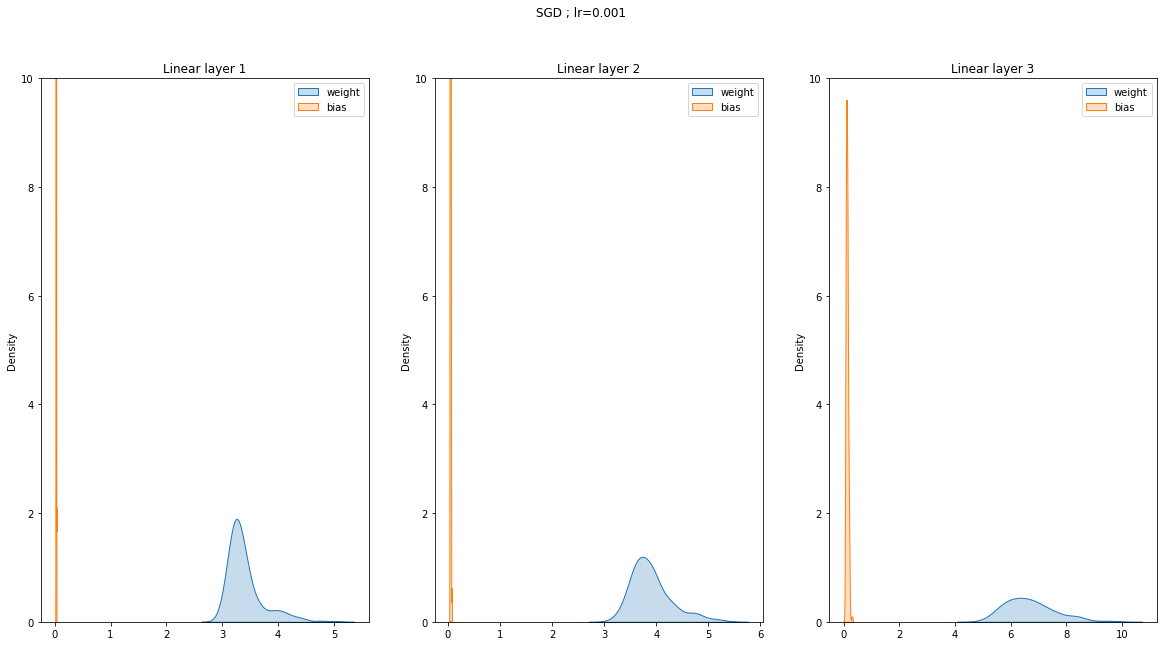

In [53]:
grad_visualize(history,optim='SGD ; lr=0.001',path='plots/SGD/lr=0.001/')

In [71]:
model = base_model_build()
model.load_state_dict(torch.load("models/SGD/vgg16-transfer-chess-sgd-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[0.8916, 1.6106, 0.3028, 0.9368, 1.1901, 3.0875]], device='cuda:0')


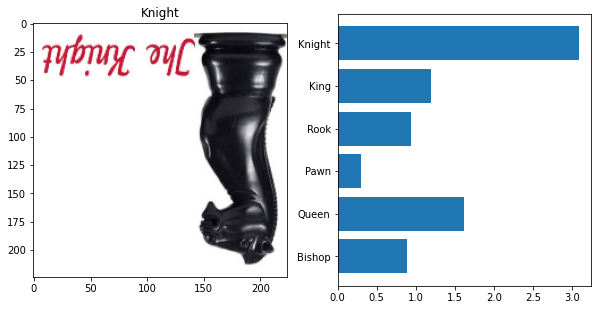

In [72]:
visual_predict(model=model)

In [73]:
sgd_lr001_dict = class_accuracies(model=model)

Accuracy for class Bishop :  0.7619047619047619
Accuracy for class Queen :  0.7894736842105263
Accuracy for class Pawn :  0.7307692307692307
Accuracy for class Rook :  0.84
Accuracy for class King :  0.7894736842105263
Accuracy for class Knight :  0.9615384615384616


In [57]:
# SGD with high learning rate

vgg16 = base_model_build()
optimizer_sgd = optim.SGD(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_sgd
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/SGD/vgg16-transfer-chess-sgd-lr=0.05'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 17.28 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 2.3021 	Validation Loss: 1.5159
		Training Accuracy: 34.72%	 Validation Accuracy: 50.74%
Epoch: 1	100.00% complete. 16.58 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.2905 	Validation Loss: 1.2411
		Training Accuracy: 54.40%	 Validation Accuracy: 55.88%
Epoch: 2	100.00% complete. 16.40 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.9935 	Validation Loss: 1.0753
		Training Accuracy: 65.97%	 Validation Accuracy: 52.21%
Epoch: 3	100.00% complete. 17.96 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.8517 	Validation Loss: 1.1552
		Training Accuracy: 69.91%	 Validation Accuracy: 55.15%
Epoch: 4	100.00% complete. 16.50 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.8131 	Validation Loss: 0.9132
		Training Accuracy: 71.06%	 Validation Accuracy: 67.65%
Epoch: 5	100.00% complete. 18.05 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

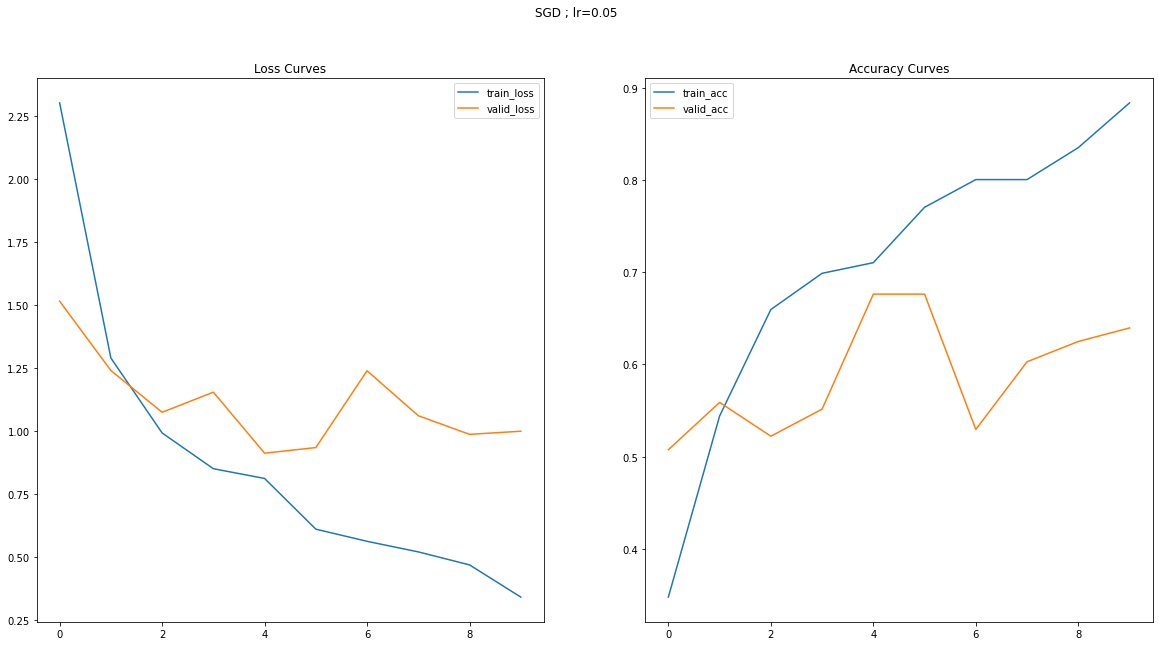

In [58]:
loss_acc_visuaize(history,optim='SGD ; lr=0.05',path='plots/SGD/lr=0.05')

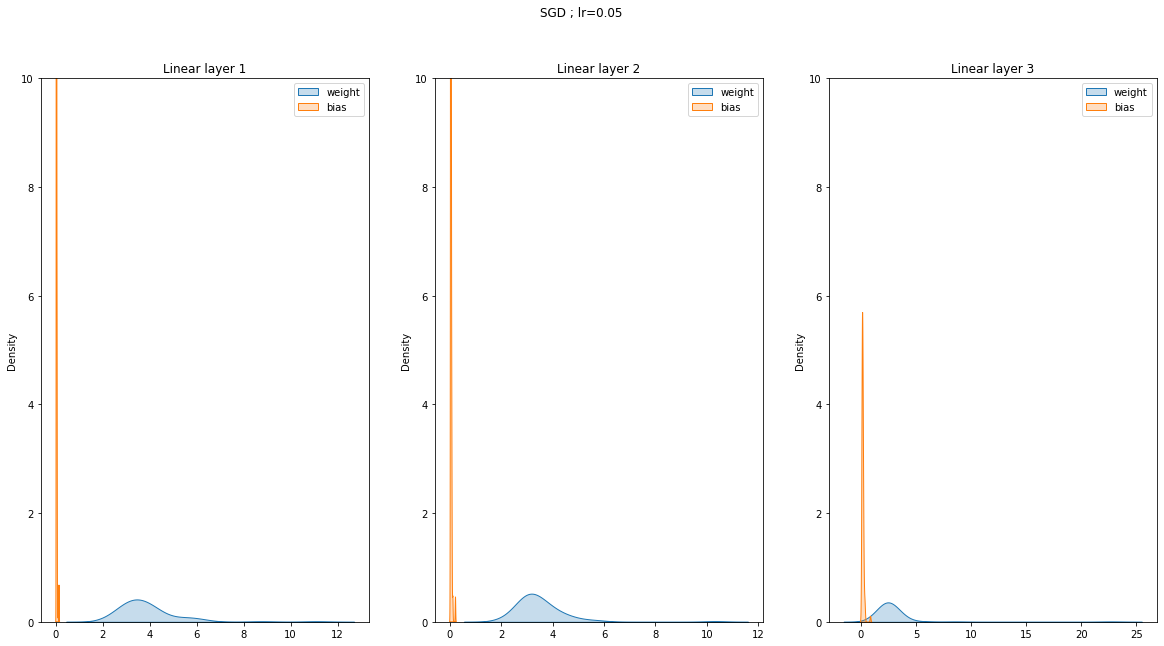

In [59]:
grad_visualize(history,optim='SGD ; lr=0.05',path='plots/SGD/lr=0.05')

In [29]:
model = base_model_build()
model.load_state_dict(torch.load("models/SGD/vgg16-transfer-chess-sgd-lr=0.05"))

training on gpu...


<All keys matched successfully>

tensor([[10.0671,  0.7721,  9.5060,  0.2429,  0.3531,  0.1408]],
       device='cuda:0')


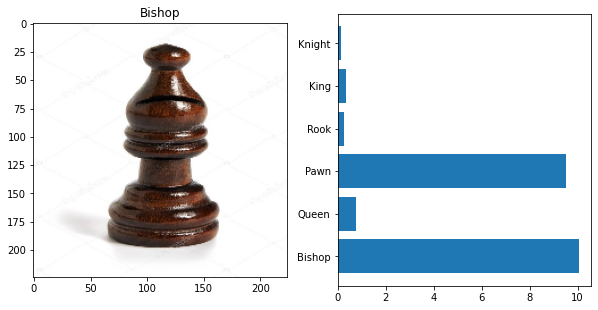

In [30]:
visual_predict(model=model)

In [31]:
sgd_lr05_dict = class_accuracies(model=model)

Accuracy for class Bishop :  0.6190476190476191
Accuracy for class Queen :  0.8421052631578947
Accuracy for class Pawn :  0.8461538461538461
Accuracy for class Rook :  0.88
Accuracy for class King :  0.8947368421052632
Accuracy for class Knight :  1.0


### **Adam**

Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. 

In [62]:
vgg16 = base_model_build()
optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/Adam/vgg16-transfer-chess-adam-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 15.89 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.8516 	Validation Loss: 1.6210
		Training Accuracy: 33.33%	 Validation Accuracy: 41.91%
Epoch: 1	100.00% complete. 17.07 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.4689 	Validation Loss: 1.3884
		Training Accuracy: 49.07%	 Validation Accuracy: 52.21%
Epoch: 2	100.00% complete. 17.23 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.2355 	Validation Loss: 1.0873
		Training Accuracy: 58.10%	 Validation Accuracy: 63.24%
Epoch: 3	100.00% complete. 16.72 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.8458 	Validation Loss: 0.8904
		Training Accuracy: 67.36%	 Validation Accuracy: 66.18%
Epoch: 4	100.00% complete. 17.05 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6389 	Validation Loss: 0.7746
		Training Accuracy: 76.62%	 Validation Accuracy: 66.91%
Epoch: 5	100.00% complete. 17.56 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

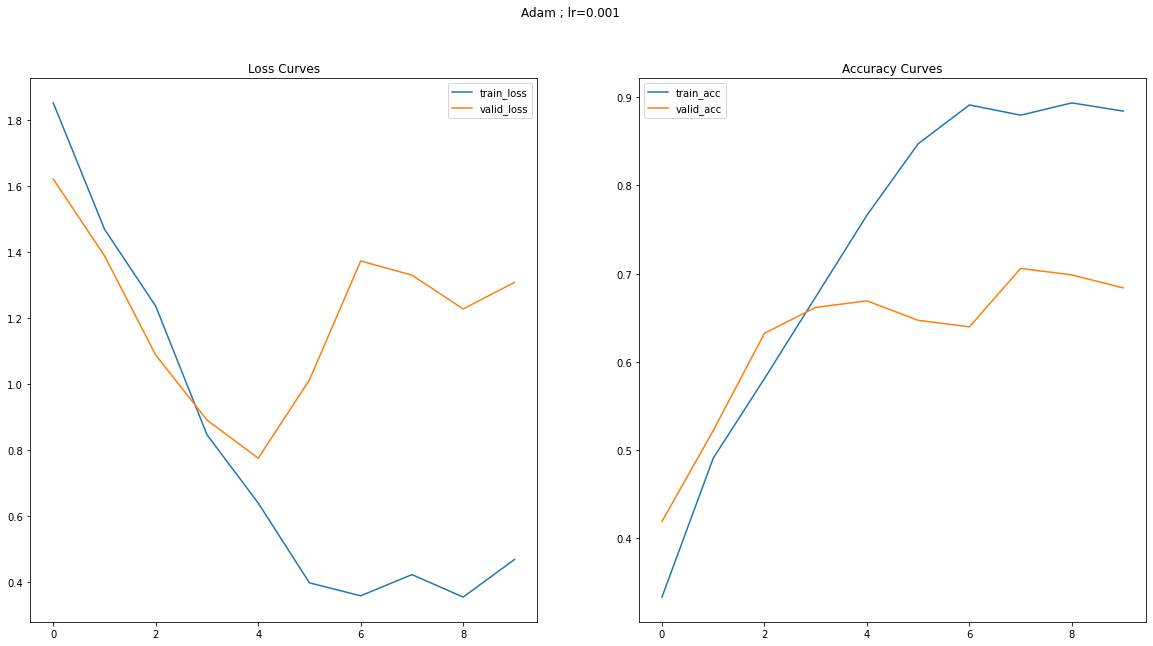

In [63]:
loss_acc_visuaize(history,optim='Adam ; lr=0.001',path='plots/Adam/lr=0.001')

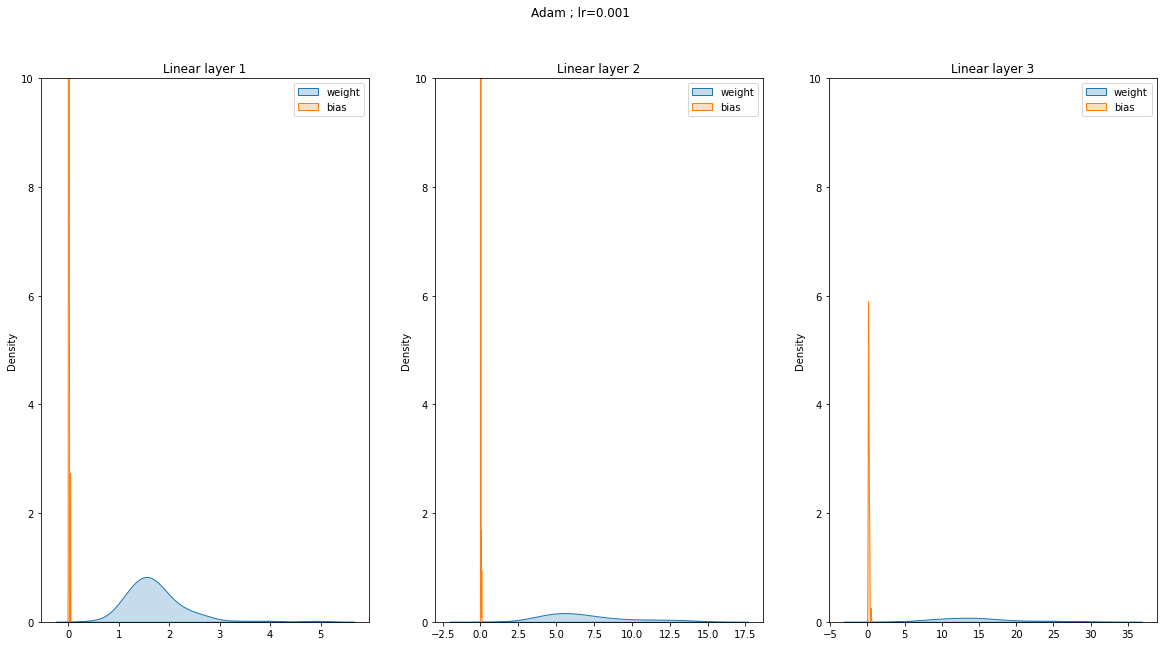

In [64]:
grad_visualize(history,optim='Adam ; lr=0.001',path='plots/Adam/lr=0.001')

In [32]:
model = base_model_build()
model.load_state_dict(torch.load("models/Adam/vgg16-transfer-chess-adam-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[5.2126e-02, 1.7025e+02, 1.1235e-02, 1.1144e-01, 2.5289e+00, 2.8729e-03]],
       device='cuda:0')


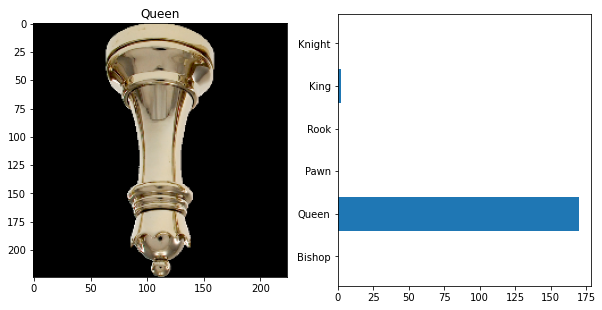

In [38]:
visual_predict(model)

In [39]:
adam_lr001_dict = class_accuracies(model=model)

Accuracy for class Bishop :  0.7619047619047619
Accuracy for class Queen :  0.8947368421052632
Accuracy for class Pawn :  0.9230769230769231
Accuracy for class Rook :  0.92
Accuracy for class King :  0.8947368421052632
Accuracy for class Knight :  1.0


In [67]:
# Adam with high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/Adam/vgg16-transfer-chess-sgd-lr=0.05'
max_epochs_stop=5
n_epochs=10
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 16.19 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 31652.4617 	Validation Loss: 2644.7386
		Training Accuracy: 15.74%	 Validation Accuracy: 14.71%
Epoch: 1	100.00% complete. 17.09 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 3330.2683 	Validation Loss: 1180.8136
		Training Accuracy: 22.92%	 Validation Accuracy: 27.94%
Epoch: 2	100.00% complete. 15.92 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1406.6930 	Validation Loss: 355.3521
		Training Accuracy: 31.48%	 Validation Accuracy: 33.82%
Epoch: 3	100.00% complete. 18.64 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 841.4076 	Validation Loss: 189.9492
		Training Accuracy: 32.41%	 Validation Accuracy: 45.59%
Epoch: 4	100.00% complete. 17.03 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 854.3636 	Validation Loss: 127.1375
		Training Accuracy: 35.88%	 Validation Accuracy: 34.56%
Epoch: 5	100.00% complete. 18.50 seconds elapsed in epoch

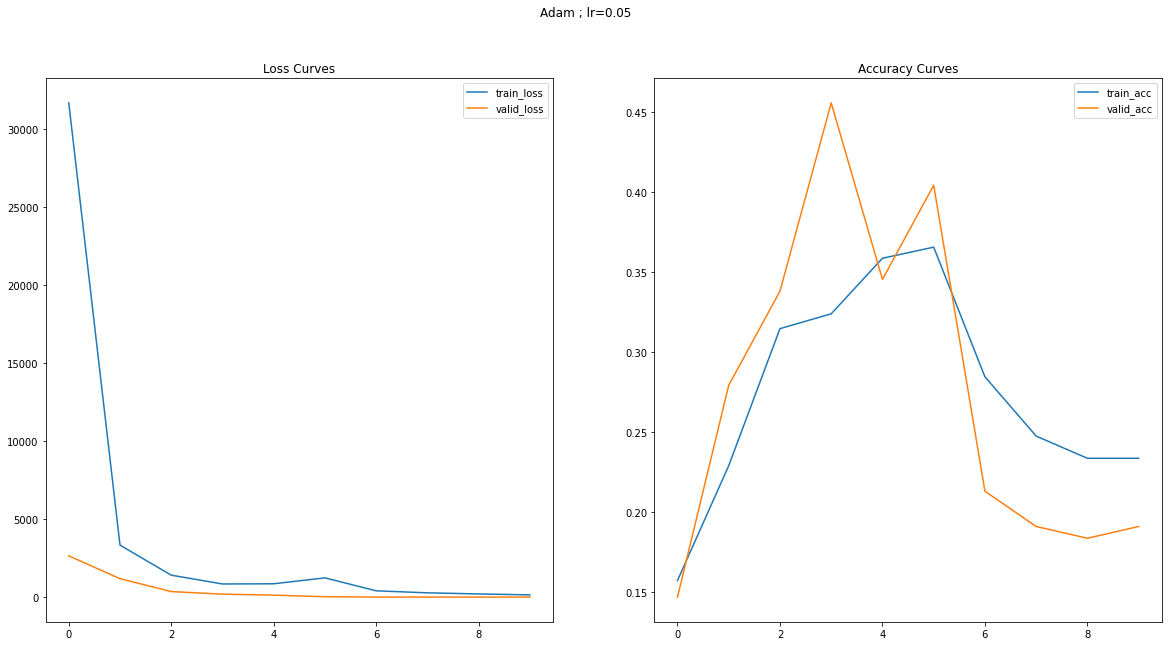

In [68]:
loss_acc_visuaize(history,optim='Adam ; lr=0.05',path='plots/Adam/lr=0.05')

### **RMSProp**

RMSprop is a gradient-based optimization technique used in training neural networks. It was proposed by the father of back-propagation, Geoffrey Hinton. Gradients of very complex functions like neural networks have a tendency to either vanish or explode as the data propagates through the function (refer to vanishing gradients problem). Rmsprop was developed as a stochastic technique for mini-batch learning.

RMSprop deals with the above issue by using a moving average of squared gradients to normalize the gradient. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing.
Simply put, RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.

In [69]:
vgg16 = base_model_build()
optimizer_adam = optim.RMSprop(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/RMSprop/vgg16-transfer-chess-rmsprop-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 17.51 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 269.4587 	Validation Loss: 21.2964
		Training Accuracy: 16.67%	 Validation Accuracy: 19.12%
Epoch: 1	100.00% complete. 17.44 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 7.4930 	Validation Loss: 1.7112
		Training Accuracy: 31.02%	 Validation Accuracy: 38.97%
Epoch: 2	100.00% complete. 15.46 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.9126 	Validation Loss: 1.2687
		Training Accuracy: 50.00%	 Validation Accuracy: 55.15%
Epoch: 3	100.00% complete. 16.99 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.3910 	Validation Loss: 1.5539
		Training Accuracy: 58.10%	 Validation Accuracy: 49.26%
Epoch: 4	100.00% complete. 16.85 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.0191 	Validation Loss: 0.9865
		Training Accuracy: 68.75%	 Validation Accuracy: 60.29%
Epoch: 5	100.00% complete. 14.78 seconds elapsed in epoch.
Epoch: 5 	Training Lo

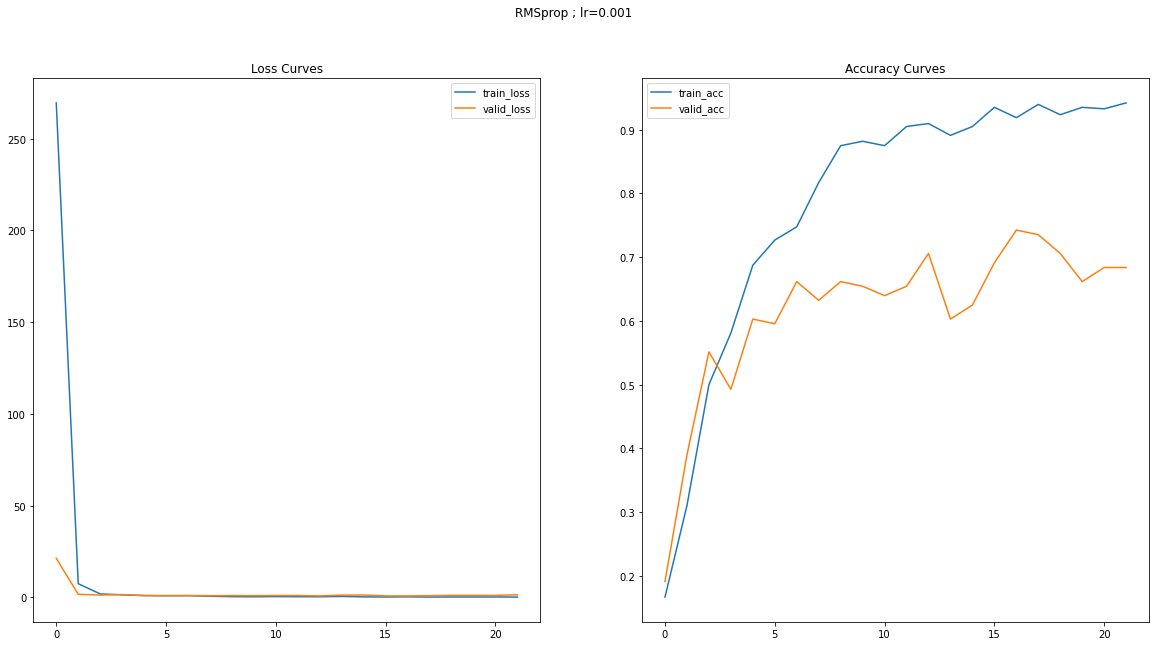

In [70]:
loss_acc_visuaize(history, optim='RMSprop ; lr=0.001',path='plots/RMSprop/lr=0.001/')

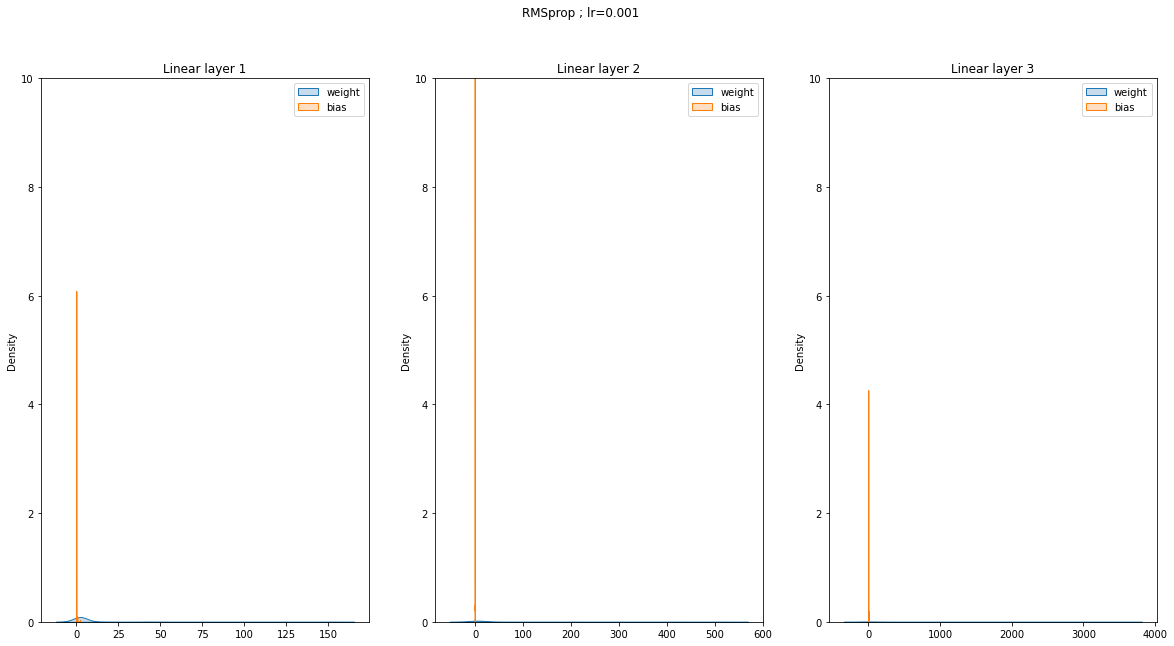

In [71]:
grad_visualize(history, optim='RMSprop ; lr=0.001',path='plots/RMSprop/lr=0.001/')

In [41]:
model = base_model_build()
model.load_state_dict(torch.load("models/RMSprop/vgg16-transfer-chess-rmsprop-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[8.7264e-01, 2.6689e+02, 5.7002e-01, 1.9107e+01, 5.1887e+04, 3.6366e-01]],
       device='cuda:0')


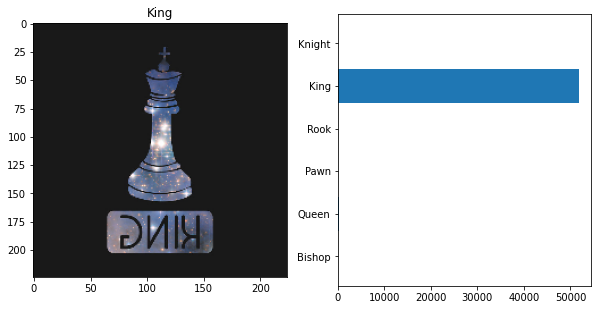

In [42]:
visual_predict(model)

In [43]:
rmsprop_lr001_dict=class_accuracies(model)

Accuracy for class Bishop :  0.8571428571428571
Accuracy for class Queen :  1.0
Accuracy for class Pawn :  0.9230769230769231
Accuracy for class Rook :  1.0
Accuracy for class King :  0.9473684210526315
Accuracy for class Knight :  1.0


In [74]:
# RMSprop with high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.RMSprop(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/RMSprop/vgg16-transfer-chess-sgd-1'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 16.78 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 24163175.5925 	Validation Loss: 2160576.7665
		Training Accuracy: 17.36%	 Validation Accuracy: 13.97%
Epoch: 1	100.00% complete. 15.36 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1142607.4994 	Validation Loss: 105707.0471
		Training Accuracy: 21.99%	 Validation Accuracy: 36.76%
Epoch: 2	100.00% complete. 16.45 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 222564.4916 	Validation Loss: 59688.8663
		Training Accuracy: 32.87%	 Validation Accuracy: 37.50%
Epoch: 3	100.00% complete. 16.61 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 105240.8273 	Validation Loss: 13653.7978
		Training Accuracy: 44.44%	 Validation Accuracy: 62.50%
Epoch: 4	100.00% complete. 14.98 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 49868.6851 	Validation Loss: 14429.9737
		Training Accuracy: 50.46%	 Validation Accuracy: 52.21%
Epoch: 5	100.00% complete. 17.49 

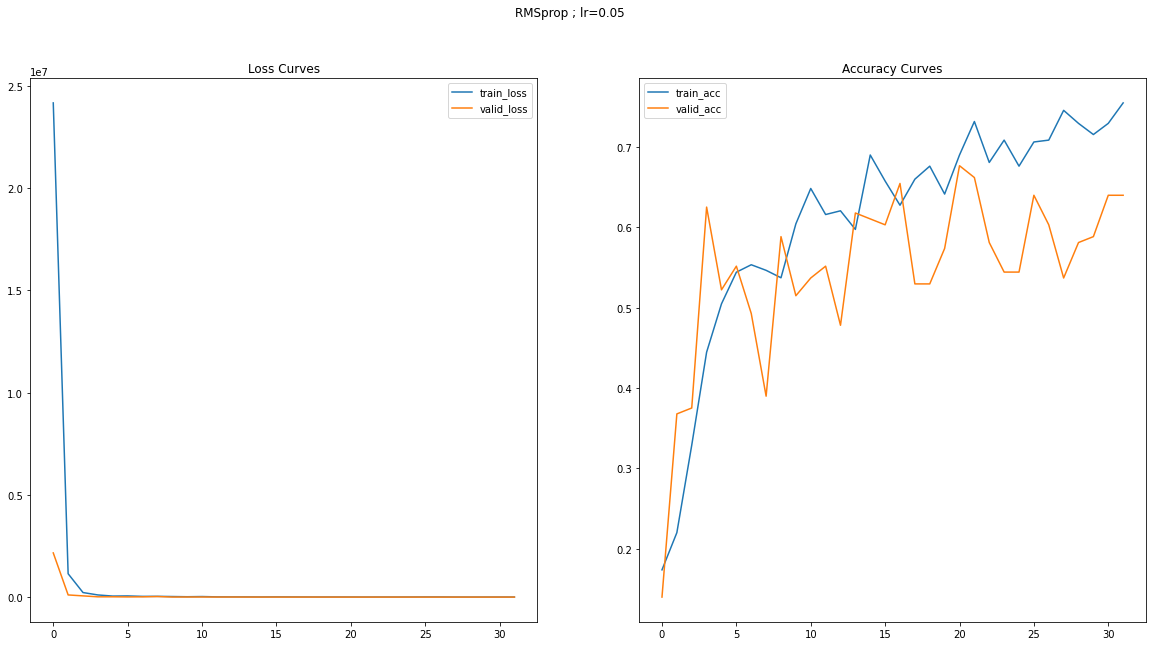

In [75]:
loss_acc_visuaize(history, optim='RMSprop ; lr=0.05',path='plots/RMSprop/lr=0.05/')

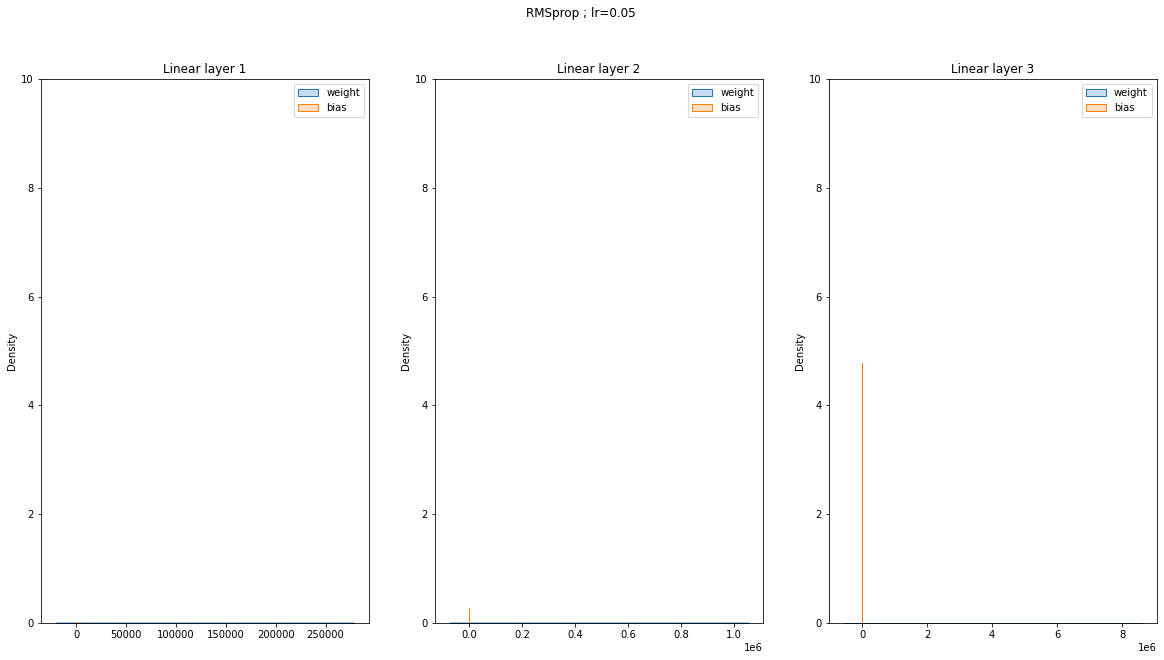

In [76]:
grad_visualize(history, optim='RMSprop ; lr=0.05',path='plots/RMSprop/lr=0.05/')

In [45]:
model = base_model_build()
model.load_state_dict(torch.load("models/RMSprop/vgg16-transfer-chess-sgd-1"))

training on gpu...


<All keys matched successfully>

tensor([[inf, inf, inf, inf, inf, 0.]], device='cuda:0')


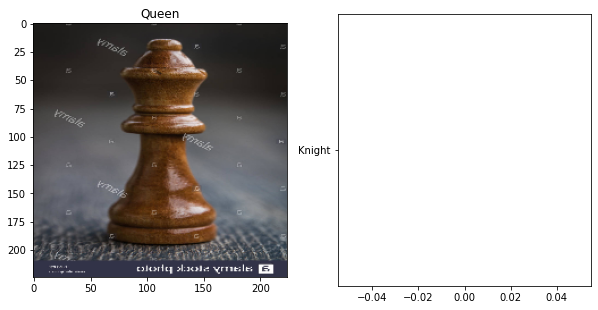

In [48]:
visual_predict(model)

In [49]:
_=class_accuracies(model)

Accuracy for class Bishop :  1.0
Accuracy for class Queen :  0.0
Accuracy for class Pawn :  0.0
Accuracy for class Rook :  0.0
Accuracy for class King :  0.0
Accuracy for class Knight :  0.0


## **Adagrad**

Adaptive Gradient Algorithm (Adagrad) is an algorithm for gradient-based optimization. The learning rate is adapted component-wise to the parameters by incorporating knowledge of past observations.  It performs larger updates (e.g. high learning rates) for those parameters that are related to infrequent features and smaller updates (i.e. low learning rates) for frequent one. It performs smaller updates As a result, it is well-suited when dealing with sparse data (NLP or image recognition) Each parameter has its own learning rate that improves performance on problems with sparse gradients.

In [79]:
vgg16 = base_model_build()
optimizer_adam = optim.Adagrad(vgg16.classifier.parameters(), lr=0.001)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/Adagrad/vgg16-transfer-chess-adagrad-lr=0.001'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 17.71 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.7728 	Validation Loss: 1.6628
		Training Accuracy: 28.94%	 Validation Accuracy: 42.65%
Epoch: 1	100.00% complete. 17.07 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.2531 	Validation Loss: 1.0819
		Training Accuracy: 52.78%	 Validation Accuracy: 60.29%
Epoch: 2	100.00% complete. 15.91 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.8556 	Validation Loss: 0.9452
		Training Accuracy: 65.74%	 Validation Accuracy: 59.56%
Epoch: 3	100.00% complete. 17.84 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.5878 	Validation Loss: 1.0296
		Training Accuracy: 78.47%	 Validation Accuracy: 54.41%
Epoch: 4	100.00% complete. 17.38 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.4812 	Validation Loss: 1.1847
		Training Accuracy: 84.49%	 Validation Accuracy: 51.47%
Epoch: 5	100.00% complete. 16.49 seconds elapsed in epoch.
Epoch: 5 	Training Loss:

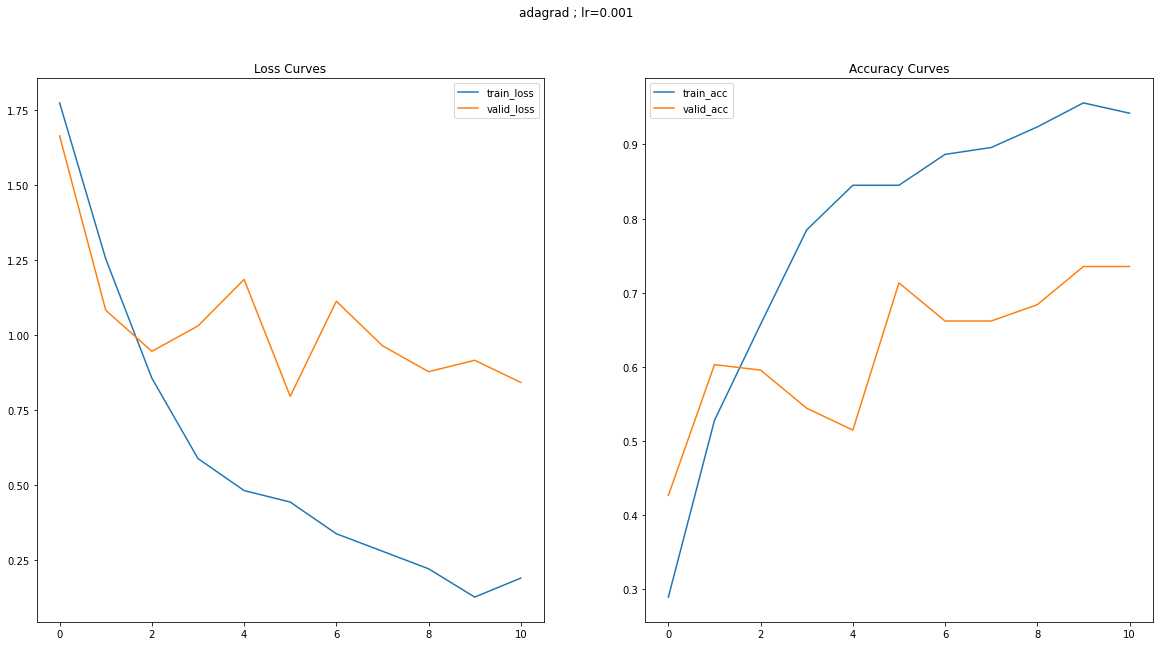

In [80]:
loss_acc_visuaize(history,optim="adagrad ; lr=0.001",path="plots/Adagrad/lr=0.001/")

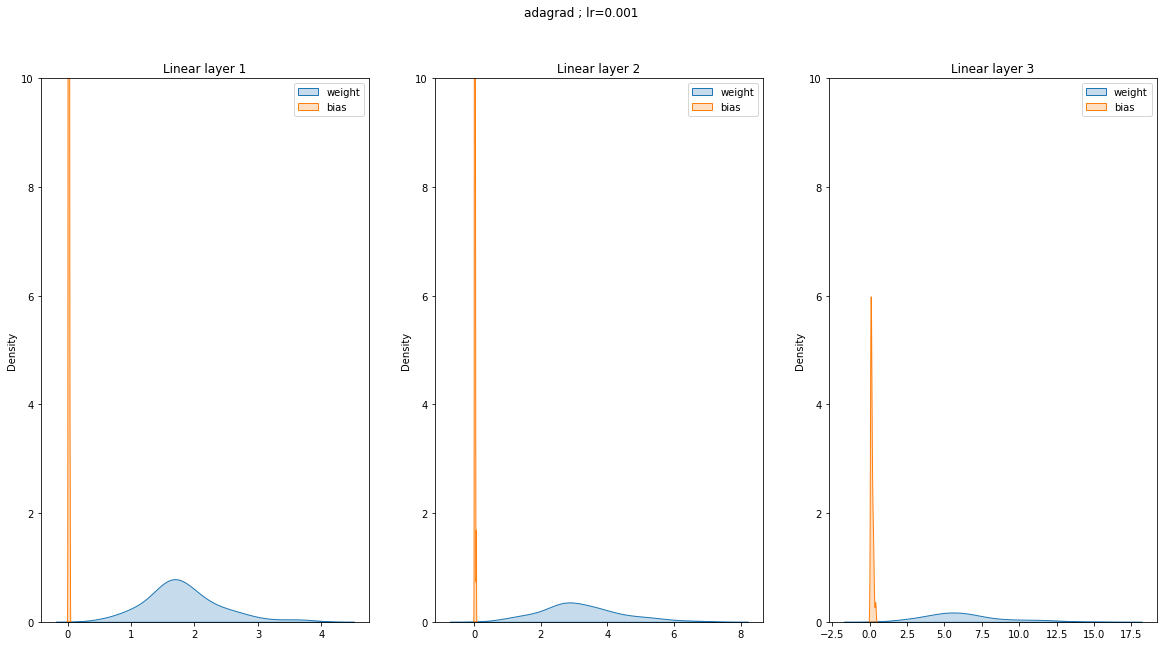

In [81]:
grad_visualize(history,optim="adagrad ; lr=0.001",path="plots/Adagrad/lr=0.001/")

In [50]:
model = base_model_build()
model.load_state_dict(torch.load("models/Adagrad/vgg16-transfer-chess-adagrad-lr=0.001"))

training on gpu...


<All keys matched successfully>

tensor([[0.9169, 0.4994, 3.7093, 0.1398, 1.9222, 2.1087]], device='cuda:0')


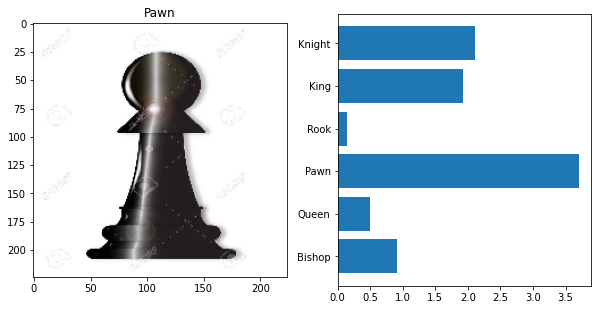

In [57]:
visual_predict(model)

In [58]:
adagrad_dict_lr001=class_accuracies(model)

Accuracy for class Bishop :  0.7142857142857143
Accuracy for class Queen :  0.8421052631578947
Accuracy for class Pawn :  0.7692307692307693
Accuracy for class Rook :  0.92
Accuracy for class King :  0.9473684210526315
Accuracy for class Knight :  1.0


In [86]:
# adagrad ; high learning rate

vgg16 = base_model_build()
optimizer_adam = optim.Adagrad(vgg16.classifier.parameters(), lr=0.05)

model=vgg16
criterion=criterion
optimizer=optimizer_adam
train_loader=train_loader
valid_loader=valid_loader
save_file_name='models/Adagrad/vgg16-transfer-chess-adagrad-lr=0.05'
max_epochs_stop=5
n_epochs=40
print_every=1

"""Train a PyTorch Model

Params
--------
    model (PyTorch model): cnn to train
    criterion (PyTorch loss): objective to minimize
    optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
    train_loader (PyTorch dataloader): training dataloader to iterate through
    valid_loader (PyTorch dataloader): validation dataloader used for early stopping
    save_file_name (str ending in '.pt'): file path to save the model state dict
    max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
    n_epochs (int): maximum number of training epochs
    print_every (int): frequency of epochs to print training stats

Returns
--------
    model (PyTorch model): trained cnn with best weights
    history (DataFrame): history of train and validation loss and accuracy
"""

# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []
bias_grads1 = []
weight_grads1 = []
bias_grads2 = []
weight_grads2 = []
bias_grads3 = []
weight_grads3 = []


# Number of epochs already trained (if using loaded in model weights)
try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

overall_start = timer()

# Main loop
for epoch in range(n_epochs):

    # keep track of training and validation loss each epoch
    train_loss = 0.0
    valid_loss = 0.0

    train_acc = 0
    valid_acc = 0

    # Set to training
    model.train()
    start = timer()

    # Training loop
    for ii, (data, target) in enumerate(train_loader):
        # Tensors to gpu
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(data)

        # Loss and backpropagation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        weight_grads1.append(np.linalg.norm(model.classifier[0].weight.grad.cpu().numpy()))
        bias_grads1.append(np.linalg.norm(model.classifier[0].bias.grad.cpu().numpy()))
        weight_grads2.append(np.linalg.norm(model.classifier[3].weight.grad.cpu().numpy()))
        bias_grads2.append(np.linalg.norm(model.classifier[3].bias.grad.cpu().numpy()))
        weight_grads3.append(np.linalg.norm(model.classifier[6].weight.grad.cpu().numpy()))
        bias_grads3.append(np.linalg.norm(model.classifier[6].bias.grad.cpu().numpy()))



        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        # Calculate accuracy by finding max log probability
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        # Need to convert correct tensor from int to float to average
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples in batch
        train_acc += accuracy.item() * data.size(0)

        # Track training progress
        print(
            f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            end='\r')

    # After training loops ends, start validation
    else:
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    break

# Attach the optimizer
model.optimizer = optimizer
# Record overall time and print out stats
total_time = timer() - overall_start
print(
    f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
)
print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
)
# Format history
history = pd.DataFrame(
    history,
    columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

training on gpu...
Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.48 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 27104.6199 	Validation Loss: 1567.8519
		Training Accuracy: 19.68%	 Validation Accuracy: 15.44%
Epoch: 1	100.00% complete. 16.09 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 768.2461 	Validation Loss: 301.4225
		Training Accuracy: 25.93%	 Validation Accuracy: 39.71%
Epoch: 2	100.00% complete. 16.47 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 215.1811 	Validation Loss: 46.2690
		Training Accuracy: 41.90%	 Validation Accuracy: 45.59%
Epoch: 3	100.00% complete. 18.27 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 44.0231 	Validation Loss: 24.0985
		Training Accuracy: 53.24%	 Validation Accuracy: 44.12%
Epoch: 4	100.00% complete. 17.98 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 33.0801 	Validation Loss: 15.7773
		Training Accuracy: 54.63%	 Validation Accuracy: 51.47%
Epoch: 5	100.00% complete. 17.02 seconds elapsed in epoch.
Epoch:

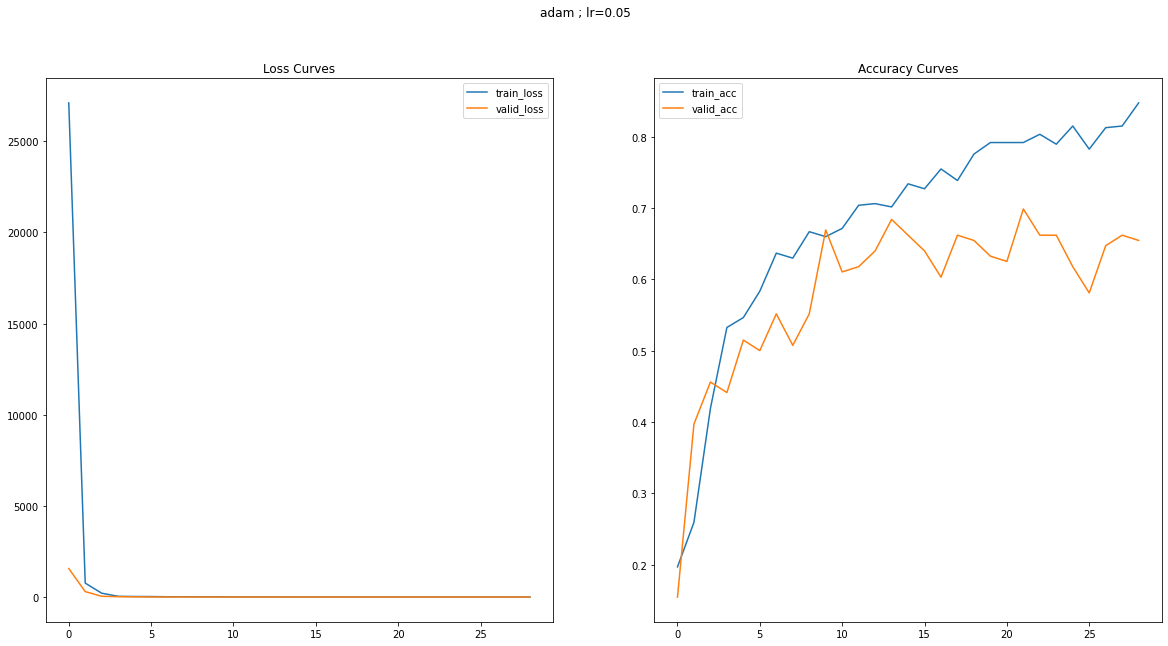

In [87]:
loss_acc_visuaize(history,optim="adam ; lr=0.05", path="plots/Adagrad/lr=0.05/")

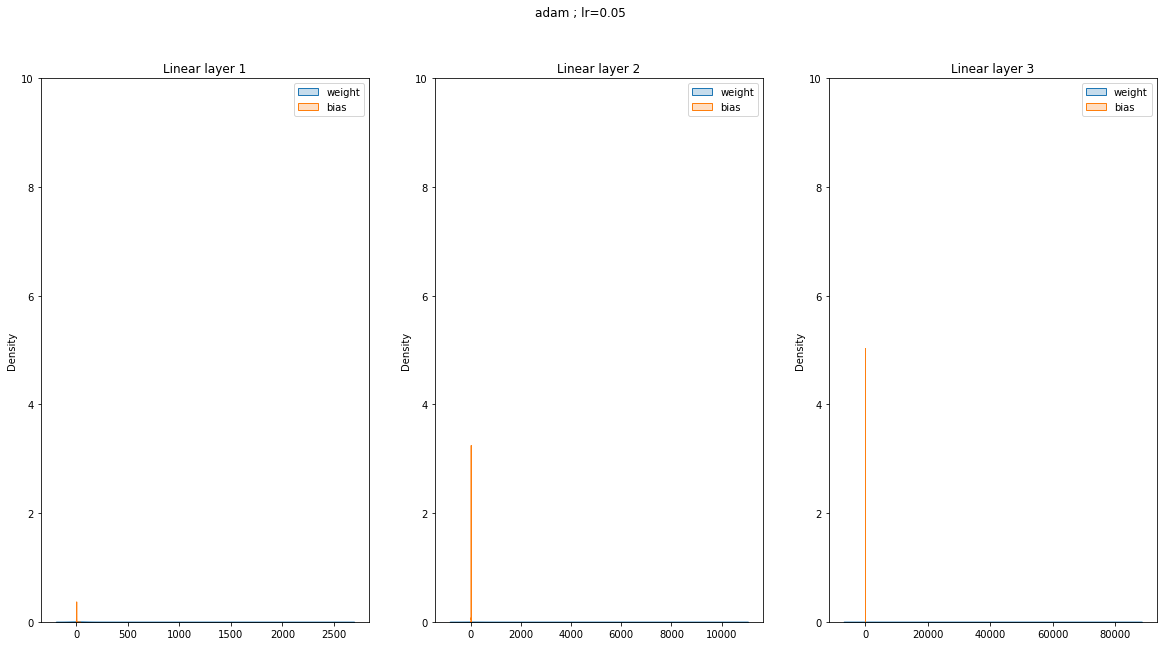

In [88]:
grad_visualize(history,optim="adam ; lr=0.05", path="plots/Adagrad/lr=0.05/")

In [60]:
model = base_model_build()
model.load_state_dict(torch.load("models/Adagrad/vgg16-transfer-chess-adagrad-lr=0.05"))

training on gpu...


<All keys matched successfully>

tensor([[1.3171e+32, 4.4620e+03, 5.9950e+10, 9.8033e-01, 6.5739e+13, 6.2738e+12]],
       device='cuda:0')


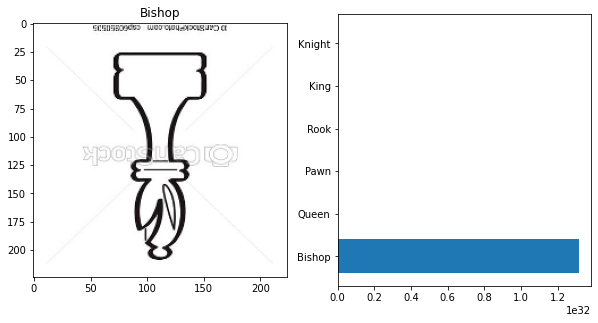

In [69]:
visual_predict(model)

In [66]:
adagrad_dict_lr05=class_accuracies(model)

Accuracy for class Bishop :  0.8095238095238095
Accuracy for class Queen :  0.7894736842105263
Accuracy for class Pawn :  0.7692307692307693
Accuracy for class Rook :  0.88
Accuracy for class King :  0.7368421052631579
Accuracy for class Knight :  0.11538461538461539


### **class accuracies for different optimizers**

In [84]:
optims = ['sgd_lr001','sgd_lr05','adam_lr001','rmsprop_lr001','adagrad_lr001','adagrad_lr05']
classcounts = {}
for c in classes:
    classcounts[str(c)] = [sgd_lr001_dict[str(c)],sgd_lr05_dict[str(c)],adam_lr001_dict[str(c)],rmsprop_lr001_dict[str(c)],adagrad_dict_lr001[str(c)],adagrad_dict_lr05[str(c)]]

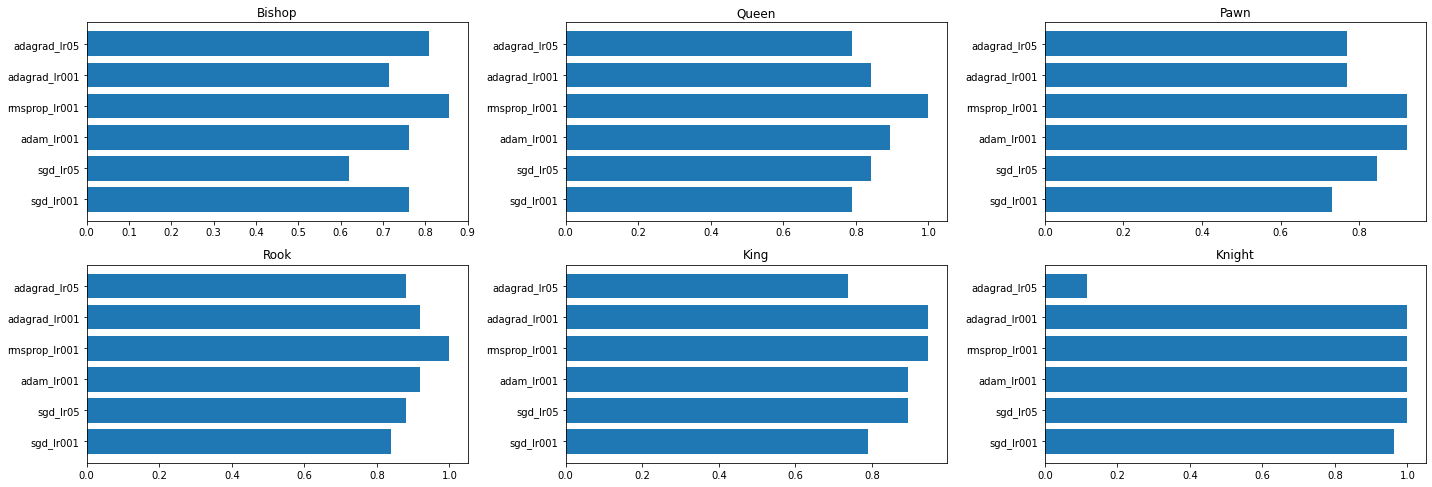

In [94]:
plt.figure(figsize=(20,10))

plt.subplot(331)
plt.barh(optims,classcounts['Bishop'])
plt.title('Bishop')

plt.subplot(332)
plt.barh(optims,classcounts['Queen'])
plt.title('Queen')

plt.subplot(333)
plt.barh(optims,classcounts['Pawn'])
plt.title('Pawn')

plt.subplot(334)
plt.barh(optims,classcounts['Rook'])
plt.title('Rook')

plt.subplot(335)
plt.barh(optims,classcounts['King'])
plt.title('King')

plt.subplot(336)
plt.barh(optims,classcounts['Knight'])
plt.title('Knight')

plt.tight_layout()

Clearly, RMSprop gives the best performance for all the classifications...!!!